In [226]:
import uproot
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import torch.cuda.amp as amp


In [127]:
zero_t_samples = [
    'data/WW.Flz.part1.root',
    'data/WW.Flz.part2.root',
    'data/Wjets-incl.INb.part1.root',
    'data/Wjets-incl.INb.part2.root',
    'data/Wjets-incl.INb.part3.root',
    'data/Wjets-incl.INb.part4.root',
    'data/Wjets-incl.INb.part5.root',
]

one_t_samples = [
    'data/t-channel_tbar_4f.leB.part1.root',
    'data/t-channel_tbar_4f.leB.part2.root',
    'data/t-channel_top_4f.qlh.part1.root',
    'data/t-channel_top_4f.qlh.part2.root',
]

two_t_samples = [
    'data/ttbar_doublelep.KQP.part1.root',
    'data/ttbar_doublelep.KQP.part2.root',
    'data/ttbar_doublelep.KQP.part3.root',
    'data/ttbar_doublelep.KQP.part4.root',
    'data/ttbar_semilep.vRt.part1.root',
    'data/ttbar_semilep.vRt.part2.root',
]

three_t_samples = [
    'data/TTTJ_UL16Summer20_RoO.root',
    'data/TTTW_UL16Summer20_CgT.root',
]

four_t_samples = [
    'data/TTTT_UL16Summer20_eIE.part1.root',
    'data/TTTT_UL16Summer20_eIE.part2.root',
    'data/TTTT_UL16Summer20_eIE.part3.root',
    'data/TTTT_UL16Summer20_eIE.part4.root',
]

# create dataframe
total_data = []
for i, samples in tqdm(enumerate([zero_t_samples,one_t_samples,two_t_samples,three_t_samples,four_t_samples])):
    list_of_samples = []
    for path in tqdm(samples):
        print('processing',i, path)
        file = uproot.open(path)
        a = file['LHE'].arrays(file['LHE'].keys(), library="np")
        df = pd.DataFrame(a)
        list_of_samples.append(df)
        print('successful')
    df_sample = pd.concat(list_of_samples).reset_index()
    df_sample['class'] = i
    total_data.append(df_sample)
data = pd.concat(total_data).reset_index()

data = data.drop(columns = ['level_0', 'index'])   
print('shape:', data.shape)
df = data

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

processing 0 data/WW.Flz.part1.root
successful
processing 0 data/WW.Flz.part2.root
successful
processing 0 data/Wjets-incl.INb.part1.root
successful
processing 0 data/Wjets-incl.INb.part2.root
successful
processing 0 data/Wjets-incl.INb.part3.root
successful
processing 0 data/Wjets-incl.INb.part4.root
successful
processing 0 data/Wjets-incl.INb.part5.root
successful


KeyboardInterrupt: 

In [ ]:
def preprocess_df(df, particle_types, features,
                         gen_particle_types, gen_features,
                         scaler=None, fit_scaler=True):
    df = df.copy()

   
  

    
    cols_to_scale = []
    for ptype, indices in particle_types.items():
        for idx in indices:
            for feat in features:
                col = f'{feat}_{ptype}{idx}'
                if col in df.columns:
                    cols_to_scale.append(col)


    for ptype, indices in gen_particle_types.items():
        for idx in indices:
            for feat in gen_features:
                col = f'{feat}_{ptype}{idx}'
                if col in df.columns:
                    cols_to_scale.append(col)

    
    global_num_cols = [col for col in df.columns if col.startswith('N_') or col == 'MeT']
    cols_to_scale += global_num_cols

    # Масштабируем
    if scaler is None:
        scaler = StandardScaler()
    if fit_scaler:
        df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    else:
        df[cols_to_scale] = scaler.transform(df[cols_to_scale])

    return df, scaler, cols_to_scale

In [ ]:
particle_types = {
    'BJet': [1, 2, 3, 4],
    'Jet': list(range(1, 13)),
    'Lep': [1, 2, 3, 4],
}

gen_particle_types = {
    'GenTop': [1, 2, 3, 4],
    'GenNu': [1, 2, 3, 4],
}

features = ['Pt', 'Eta', 'Phi', 'Px', 'Py', 'Pz']

# 1. Формируем список колонок для входа (конечные частицы)
input_particle_cols = []
for ptype, indices in particle_types.items():
    for idx in indices:
        for feat in features:
            col = f"{feat}_{ptype}{idx}"
            input_particle_cols.append(col)

# 2. Глобальные входные признаки
input_global_cols = ["N_J", "N_BJ", "N_Nu", "N_Lep", "MeT"]

# 3. Целевые колонки — только для GenTop и GenNu
target_cols = []
for ptype, indices in gen_particle_types.items():
    for idx in indices:
        for feat in features:
            col = f"{feat}_{ptype}{idx}"
            target_cols.append(col)

# Добавим целевые глобальные переменные
target_cols += ['N_GenTop', 'N_GenNu']
df, scaler, cols = preprocess_df(df, particle_types, features,
                         gen_particle_types, features,
                         scaler=None, fit_scaler=True)
df_train, df_val = train_test_split(df.drop(columns= 'class'), test_size=0.2, stratify=df['class'], shuffle=True)

In [ ]:
class HEPEvtDataset(Dataset):
    def __init__(self, df, input_particle_cols, input_global_cols, target_cols, num_particles=20, particle_feat_dim=6):
        """
        df: pandas DataFrame с данными
        input_particle_cols: список колонок для признаков частиц (в правильном порядке)
        input_global_cols: список колонок глобальных переменных (например, N_GenTop, N_GenNu)
        target_cols: список колонок с целевыми генераторными признаками
        """
        self.df = df.reset_index(drop=True)
        self.input_particle_cols = input_particle_cols
        self.input_global_cols = input_global_cols
        self.target_cols = target_cols
        self.num_particles = num_particles
        self.particle_feat_dim = particle_feat_dim

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        particles = torch.tensor(row[self.input_particle_cols].values.reshape(self.num_particles, self.particle_feat_dim), dtype=torch.float32)
        global_feats = torch.tensor(row[self.input_global_cols].values, dtype=torch.float32)
        targets = torch.tensor(row[self.target_cols].values, dtype=torch.float32)
        return particles, global_feats, targets



In [ ]:
num_particles = 20       # число конечных частиц
particle_feat_dim = 6    # число признаков на частицу
global_feat_dim = 2      # N_GenTop и N_GenNu
num_gen_tops = 4
num_gen_nus = 4

train_dataset = HEPEvtDataset(df_train, input_particle_cols, input_global_cols, target_cols,
                             num_particles=num_particles, particle_feat_dim=particle_feat_dim)
val_dataset = HEPEvtDataset(df_val, input_particle_cols, input_global_cols, target_cols,
                           num_particles=num_particles, particle_feat_dim=particle_feat_dim)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=6)

In [ ]:
class Masker(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        weights = self.net(x).squeeze(-1)  # [B, N]
        return weights.unsqueeze(-1)       # [B, N, 1]

class AEEncoder(nn.Module):
    def __init__(self, num_particles=20, particle_feat_dim=6, global_feat_dim=5, emb_dim=64, num_heads=4):
        super().__init__()

        self.masker = Masker(particle_feat_dim)

        self.particle_proj = nn.Sequential(
            nn.Linear(particle_feat_dim, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, emb_dim)
        )

        self.attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_heads, batch_first=True)

        self.particle_pool = nn.AdaptiveAvgPool1d(1)

        self.global_net = nn.Sequential(
            nn.Linear(global_feat_dim, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, emb_dim),
            nn.LayerNorm(emb_dim)
        )

        self.combined_proj = nn.Linear(emb_dim * 2, emb_dim)

    def forward(self, particles, global_feats):
        weights = self.masker(particles)             # [B, N, 1]
        x = self.particle_proj(particles)            # [B, N, emb_dim]
        x = x * weights                              # soft masking

        attn_out, _ = self.attn(x, x, x)             # attention без key_padding_mask
        pooled_particles = self.particle_pool(attn_out.transpose(1, 2)).squeeze(-1)  # [B, emb_dim]

        global_emb = self.global_net(global_feats)   # [B, emb_dim]

        combined = torch.cat([pooled_particles, global_emb], dim=1)  # [B, emb_dim*2]

        emb = self.combined_proj(combined)           # [B, emb_dim]

        return emb, weights

class AEDecoder(nn.Module):
    def __init__(self, num_particles=20, particle_feat_dim=6, global_feat_dim=5, emb_dim=64):
        super().__init__()

        output_dim = num_particles * particle_feat_dim + global_feat_dim

        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, output_dim)
        )

        self.num_particles = num_particles
        self.particle_feat_dim = particle_feat_dim
        self.global_feat_dim = global_feat_dim

    def forward(self, emb):
        out = self.decoder(emb)
        particles = out[:, :self.num_particles * self.particle_feat_dim]
        global_feats = out[:, self.num_particles * self.particle_feat_dim:]
        particles = particles.view(-1, self.num_particles, self.particle_feat_dim)
        return particles, global_feats

class Autoencoder(nn.Module):
    def __init__(self, num_particles=20, particle_feat_dim=6, global_feat_dim=5, emb_dim=64, num_heads=4):
        super().__init__()

        self.encoder = AEEncoder(num_particles, particle_feat_dim, global_feat_dim, emb_dim, num_heads)
        self.decoder = AEDecoder(num_particles, particle_feat_dim, global_feat_dim, emb_dim)

    def forward(self, particles, global_feats):
        emb, weights = self.encoder(particles, global_feats)
        particles_recon, global_recon = self.decoder(emb)
        return particles_recon, global_recon, emb, weights

class EncoderRegressor(nn.Module):
    def __init__(self, emb_dim=64, num_gen_tops=4, num_gen_nus=4, num_gen_glob=2):
        super(EncoderRegressor, self).__init__()

        
        self.emb_dim = emb_dim

        
        self.fc1 = nn.Linear(emb_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        
        output_dim = (num_gen_tops + num_gen_nus) * 6 + num_gen_glob  
        self.fc_out = nn.Linear(128, output_dim)

        # Слои нормализации и активации
        self.layer_norm = nn.LayerNorm(64)
        self.activation = nn.ReLU()

    def forward(self, embeddings):
        
        x = embeddings

        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)

        
        output = self.fc_out(x)
        return output

class AERegressor(nn.Module):
    def __init__(self, encoder, regressor):
        super().__init__()
        self.encoder = encoder
        self.regressor = regressor

    def forward(self, particles, global_feats):
        embedding, _ = self.encoder(particles, global_feats)
        output = self.regressor(embedding)
        return output

In [ ]:
autoencoder = Autoencoder()
encoder = autoencoder.encoder
regressor = EncoderRegressor()
model = AERegressor(encoder, regressor)

In [ ]:
weights_path = 'best_ae_regressor.pt'
state_dict = torch.load(weights_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def count_valid_particles(df, particle_types, features, threshold_top=0.1, threshhold_nu=0.1):
    """
    Для каждого события в датафрейме проверяем, сколько частиц имеют ненулевые кинематические характеристики.
    Если P_x, P_y, P_z все меньше чем threshold по модулю, то заменяем значения на 0.
    
    df: pandas DataFrame, содержащий данные о частицах
    particle_types: словарь с типами частиц
    features: список признаков, например ['Pt', 'Eta', 'Phi', 'Px', 'Py', 'Pz']
    threshold: пороговое значение для P_x, P_y, P_z, ниже которого частица считается нерегистрируемой
    """

    # Создаем копию датафрейма, чтобы не изменять исходные данные
    df = df.copy()

    # Обрабатываем частицы для каждого типа
    for ptype, indices in particle_types.items():
        for idx in indices:
            # Определяем колонки для текущей частицы
            px_col = f"Px_{ptype}{idx}"
            py_col = f"Py_{ptype}{idx}"
            pz_col = f"Pz_{ptype}{idx}"
            pt_col = f"Pt_{ptype}{idx}"
            eta_col = f"Eta_{ptype}{idx}"
            phi_col = f"Phi_{ptype}{idx}"

            # Проверяем, если компоненты импульса меньше порога
            if ptype == 'GenTop':
                condition = (df[px_col].abs() < threshold_top) & (df[py_col].abs() < threshold_top) & (df[pz_col].abs() < threshold_top)
            if ptype == 'GenNu':
                condition = (df[px_col].abs() < threshhold_nu) & (df[py_col].abs() < threshhold_nu) & (df[pz_col].abs() < threshhold_nu)
            
            # Заменяем компоненты на 0 для таких частиц
            df.loc[condition, [pt_col, eta_col, phi_col, px_col, py_col, pz_col]] = 0

    # Теперь считаем количество валидных частиц для каждого события
    valid_particles_top = []
    valid_particles_nu = []

    for idx, row in df.iterrows():
        valid_top_count = 0
        valid_nu_count = 0
        
        for ptype, indices in particle_types.items():
            for idx in indices:
                # Для каждой частицы проверяем, есть ли ненулевые компоненты
                px_col = f"Px_{ptype}{idx}"
                py_col = f"Py_{ptype}{idx}"
                pz_col = f"Pz_{ptype}{idx}"
                pt_col = f"Pt_{ptype}{idx}"
                eta_col = f"Eta_{ptype}{idx}"
                phi_col = f"Phi_{ptype}{idx}"

                # Если хотя бы один из компонентов не равен нулю, частица считается валидной
                valid = (row[pt_col] != 0) or (row[px_col] != 0) or (row[py_col] != 0) or (row[pz_col] != 0) \
                        or (row[eta_col] != 0) or (row[phi_col] != 0)

                # Считаем валидные частицы для топов и нейтрино
                if ptype == 'GenTop' and valid:
                    valid_top_count += 1
                elif ptype == 'GenNu' and valid:
                    valid_nu_count += 1

        # Добавляем посчитанные значения в новые столбцы для каждого события
        valid_particles_top.append(valid_top_count)
        valid_particles_nu.append(valid_nu_count)

    # Добавляем столбцы с результатами в датафрейм
    df['N_GenTop'] = valid_particles_top
    df['N_GenNu'] = valid_particles_nu

    return df




In [ ]:
def get_postprocessed_data(model, val_loader, df_val):
    val_data = []
    device = 'cuda'
    model.to(device)
    with torch.no_grad():
        for particles, global_feats, targets in tqdm(val_loader):
            particles = particles.to(device)
            global_feats = global_feats.to(device)
            targets = targets.to(device)
            outputs = model(particles, global_feats)
            val_data.append(outputs.cpu().numpy())
    reconstructed = []
    for batch in val_data:
        for array in batch:
            reconstructed.append(array)
    reconst_events = df_val.copy()
    reconst_events[target_cols] =  recon_df.values
    df_val_new = count_valid_particles(df_val.sort_index(), gen_particle_types, features, threshold_top=100, threshhold_nu=20)
    reconst_events_new = count_valid_particles(reconst_events.sort_index(), gen_particle_types, features, threshold_top=100, threshhold_nu=20)
    for i in range(1,5):
        reg_top = LinearRegression()
        reg_top = reg_top.fit(reconst_events_new[f'Pt_GenTop{i}'].values.reshape(-1,1), df_val_new[f'Pt_GenTop{i}'].values.reshape(-1,1))
        reg_nu = LinearRegression()
        reg_nu = reg_top.fit(reconst_events_new[f'Pt_GenNu{i}'].values.reshape(-1,1), df_val_new[f'Pt_GenNu{i}'].values.reshape(-1,1))
        reconst_events_new[f'Pt_GenTop{i}'] = reconst_events_new[f'Pt_GenTop{i}'].apply(lambda x: x*reg_top.coef_[0][0])
        reconst_events_new[f'Pt_GenNu{i}'] = reconst_events_new[f'Pt_GenNu{i}'].apply(lambda x: x*reg_nu.coef_[0][0])
    return reconst_events_new, df_val_new

In [ ]:
val_data = []
device = 'cuda'
model.to(device)
with torch.no_grad():
    for particles, global_feats, targets in tqdm(val_loader):
        particles = particles.to(device)
        global_feats = global_feats.to(device)
        targets = targets.to(device)
        outputs = model(particles, global_feats)
        val_data.append(outputs.cpu().numpy())


    
    

  0%|          | 0/6406 [00:09<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40><function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40><function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40><function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40><function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40><function _MultiProcessingDataLoaderIter.__del__ at 0x7ffa558b2d40>





Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/hep/home/vasil/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/hep/home/vasil/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/hep/home/va

In [ ]:
reconstructed = []
for batch in val_data:
    for array in batch:
        reconstructed.append(array)

In [ ]:
reconst_events = df_val.copy()
reconst_events[target_cols] =  recon_df.values


In [208]:
# df_val_new = count_valid_particles(df_val, gen_particle_types, features, threshold_top=100, threshhold_nu=5)
reconst_events_new = count_valid_particles(reconst_events, gen_particle_types, features, threshold_top=100, threshhold_nu=20)

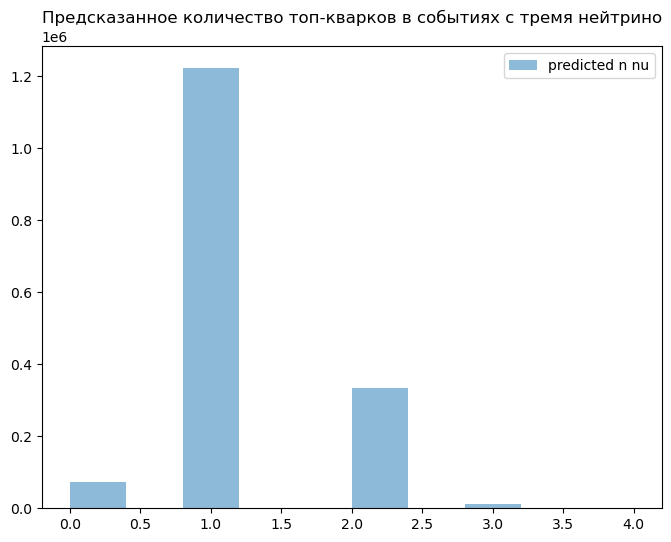

In [211]:
plt.figure(figsize=(8, 6))
plt.hist(df_val_new['N_GenNu'], alpha = 0.5, label ='predicted n nu')
plt.title('Предсказанное количество топ-кварков в событиях с тремя нейтрино')
plt.legend()

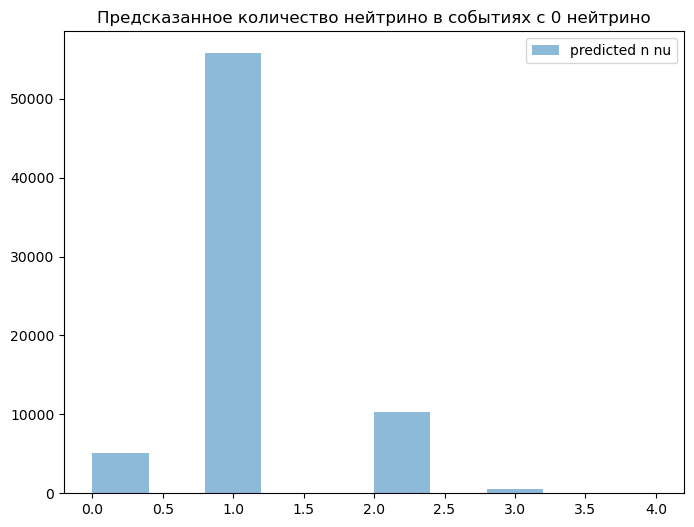

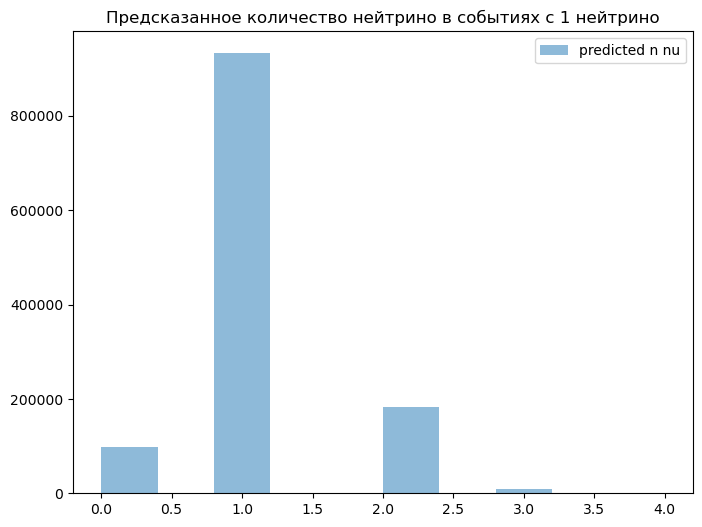

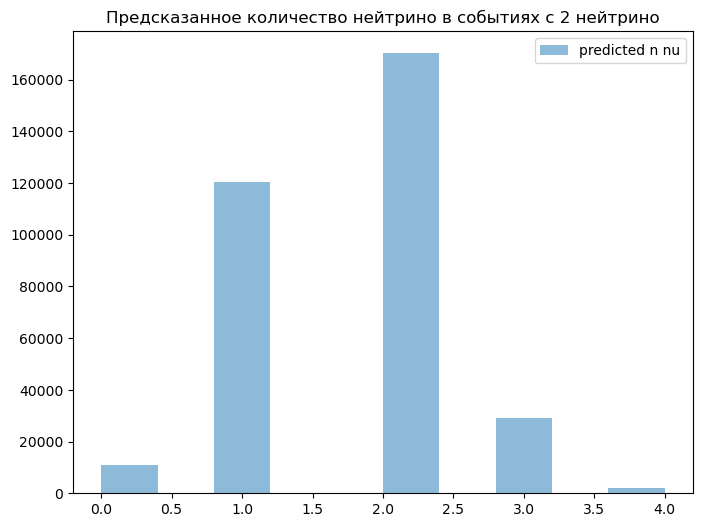

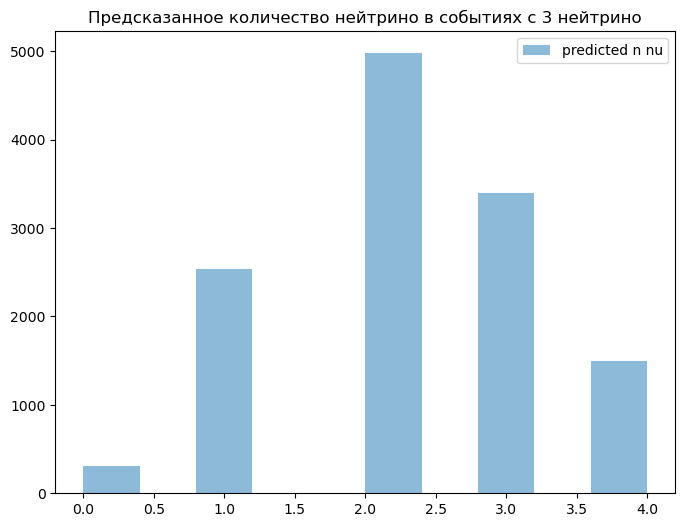

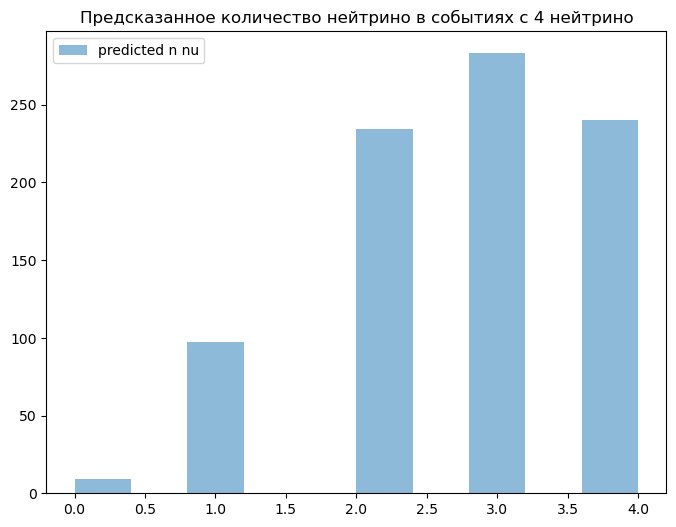

In [244]:
for i in range(5):
    plt.figure(figsize=(8, 6))
    plt.hist(reconst_events_new[df_val_new['N_GenNu'] == i]['N_GenNu'], alpha = 0.5, label ='predicted n nu')
    plt.title(f'Предсказанное количество нейтрино в событиях с {i} нейтрино')
    plt.legend()
    plt.savefig(f'results/pred_n_nu_{i}.png')
    plt.show()

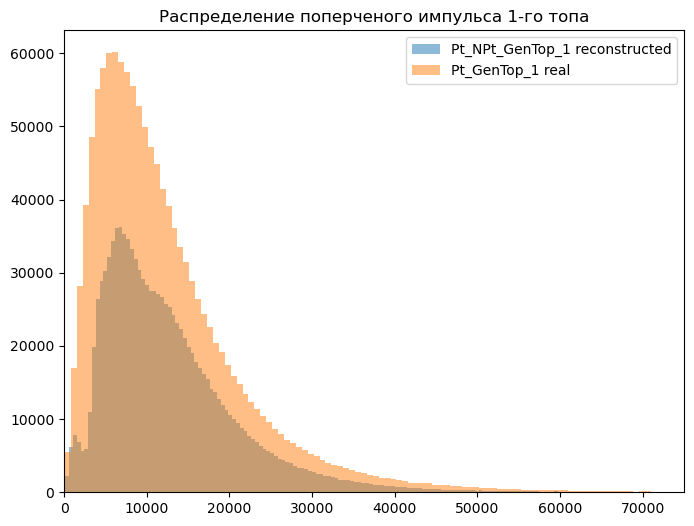

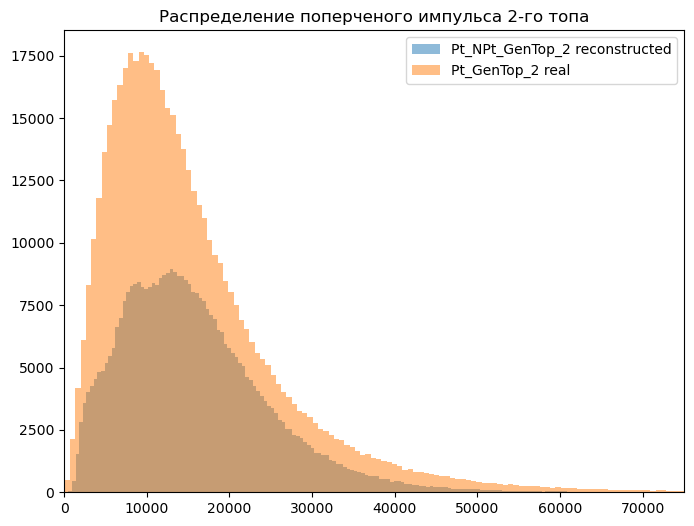

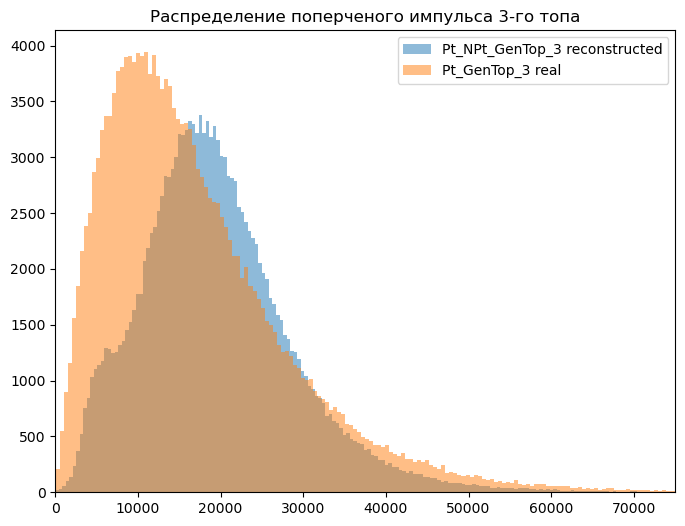

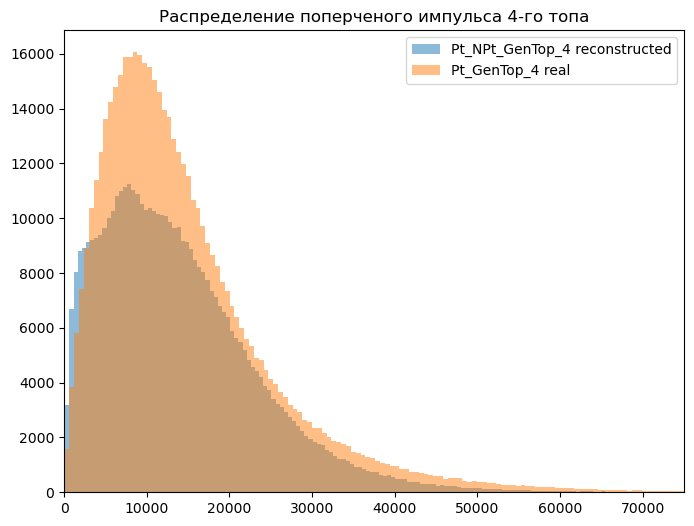

In [263]:
for i in range(1,5):
    plt.figure(figsize=(8,6))
    plt.hist(reconst_events_new[reconst_events_new[f'Pt_GenTop{i}']!=0][f'Pt_GenTop{i}']*100, bins=300, alpha=0.5, label=f'Pt_NPt_GenTop_{i} reconstructed')
    plt.hist(df_val_new[df_val_new[f'Pt_GenTop{i}']!=0][f'Pt_GenTop{i}'], bins=300, alpha=0.5, label=f'Pt_GenTop_{i} real')
    plt.xlim(0, 75000)
    plt.legend()
    plt.title(f'Распределение поперченого импульса {i}-го топа')
    plt.savefig(f'results/results_ae_reg/pt_nu_{i}.png')
    plt.show()

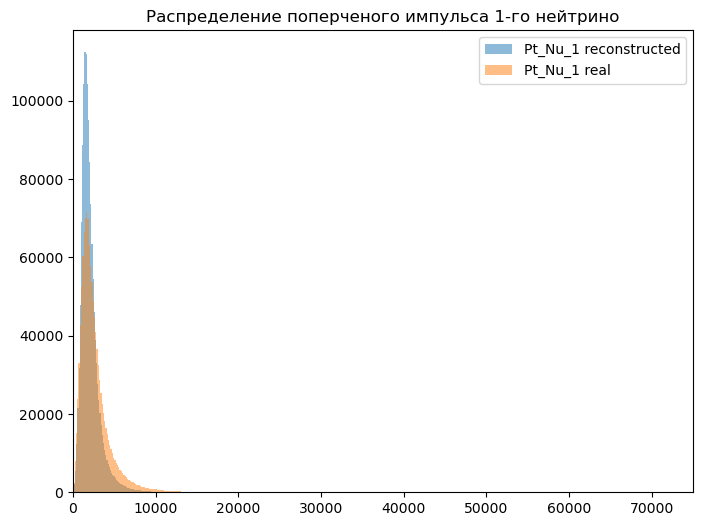

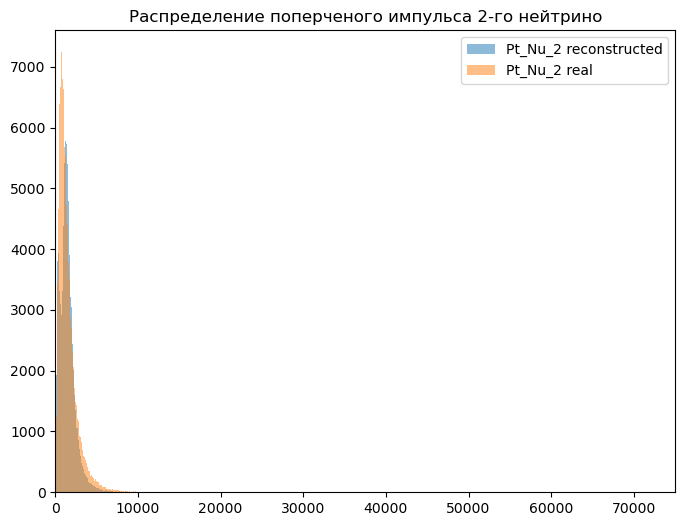

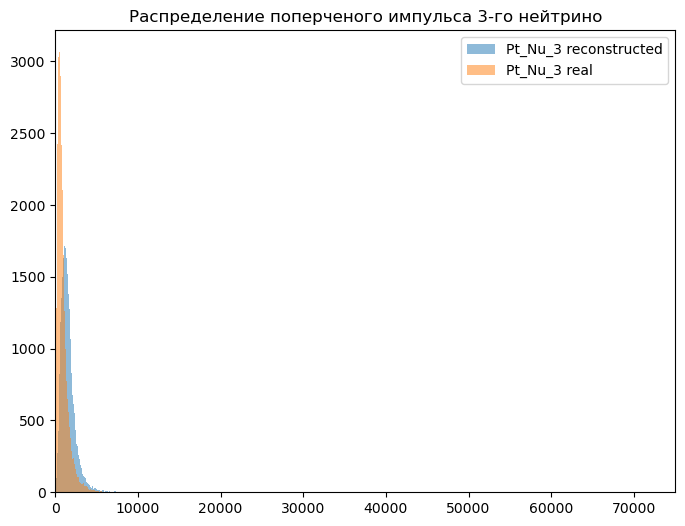

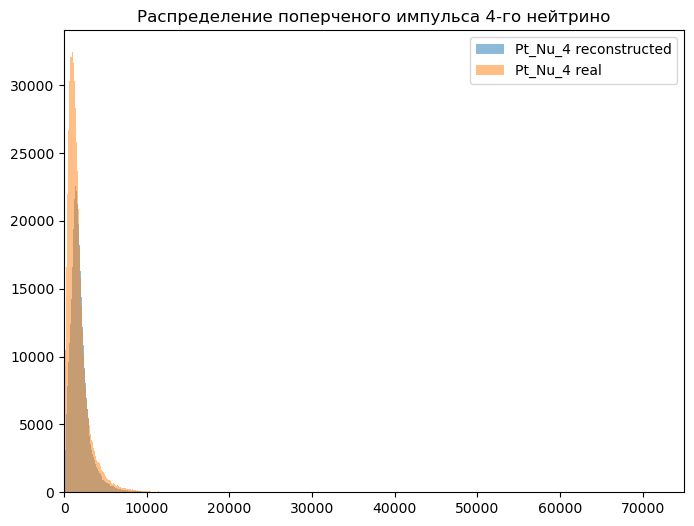

In [261]:
for i in range(1,5):
    plt.figure(figsize=(8,6))
    plt.hist(reconst_events_new[reconst_events_new[f'Pt_GenNu{i}']!=0][f'Pt_GenNu{i}']*44, bins=300, alpha=0.5, label=f'Pt_Nu_{i} reconstructed')
    plt.hist(df_val_new[df_val_new[f'Pt_GenNu{i}']!=0][f'Pt_GenNu{i}'], bins=300, alpha=0.5, label=f'Pt_Nu_{i} real')
    plt.xlim(0, 75000)
    plt.legend()
    plt.title(f'Распределение поперченого импульса {i}-го нейтрино')
    plt.savefig(f'results/results_ae_reg/pt_nu_{i}.png')
    plt.show()

In [254]:
print(df_val_new[df_val_new[f'Pt_GenNu{1}']!=0][f'Pt_GenNu{1}'].describe())
print(reconst_events_new[reconst_events_new[f'Pt_GenNu{1}']!=0][f'Pt_GenNu{1}'].describe())

count    1.204045e+06
mean     2.625373e+03
std      1.967891e+03
min      4.565413e+01
25%      1.432659e+03
50%      2.119356e+03
75%      3.189787e+03
max      4.650972e+04
Name: Pt_GenNu1, dtype: float64
count    1.418996e+06
mean     4.700026e+01
std      2.727195e+01
min     -5.478594e+01
25%      3.055891e+01
50%      4.088902e+01
75%      5.574153e+01
max      9.030627e+02
Name: Pt_GenNu1, dtype: float64


In [ ]:
for i in range(1,5):
    plt.figure(figsize=(8,6))
    plt.hist(reconst_events_new[reconst_events_new[f'Pt_GenTop{i}']!=0][f'Pt_GenTop{i}']*100, bins=300, alpha=0.5, label=f'Pt_Top_{i} reconstructed')
    plt.hist(df_val_new[df_val_new[f'Pt_GenTop{i}']!=0][f'Pt_GenTop{i}'], bins=300, alpha=0.5, label=f'Pt_Top_{i} real')
    plt.xlim(0, 75000)
    plt.legend()
    plt.title(f'Распределение поперченого импульса {i}-го топ-кварка')
    plt.savefig(f'results/results_ae_reg/pt_top_{i}.png')
    plt.show()

In [318]:
linreg = LinearRegression(fit_intercept=True)
linreg = linreg.fit((reconst_events_new['Pt_GenTop1'].values).reshape(-1,1), df_val_new['Pt_GenTop1'].values.reshape(-1,1))

In [320]:
linreg.coef_[0][0]

89.07807266468956

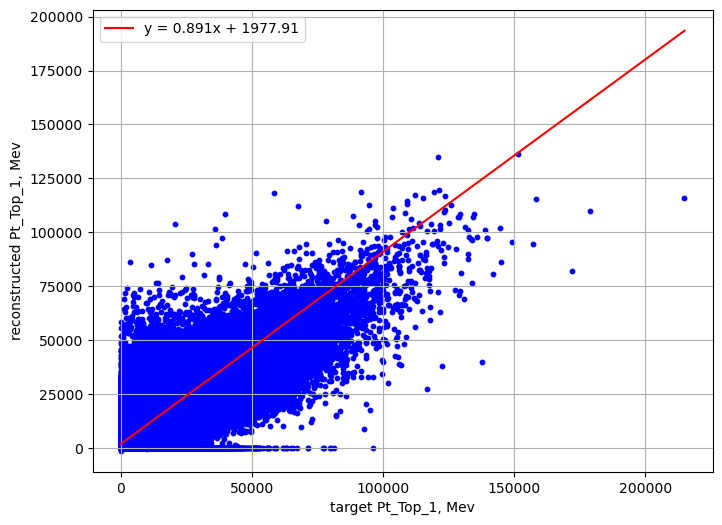

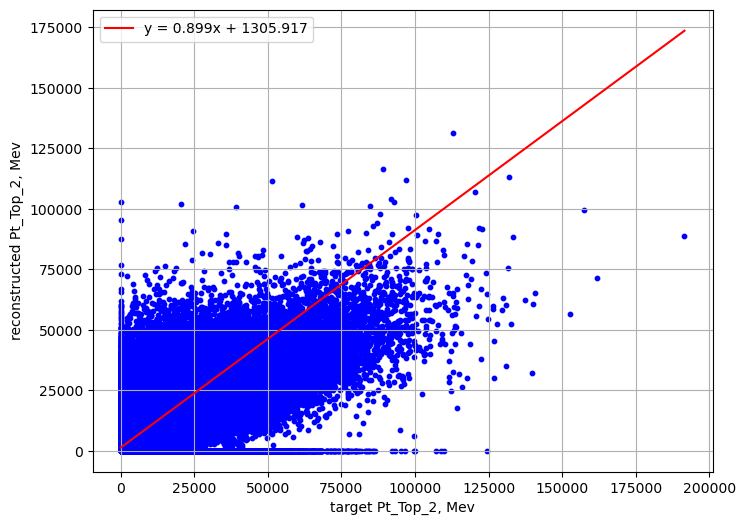

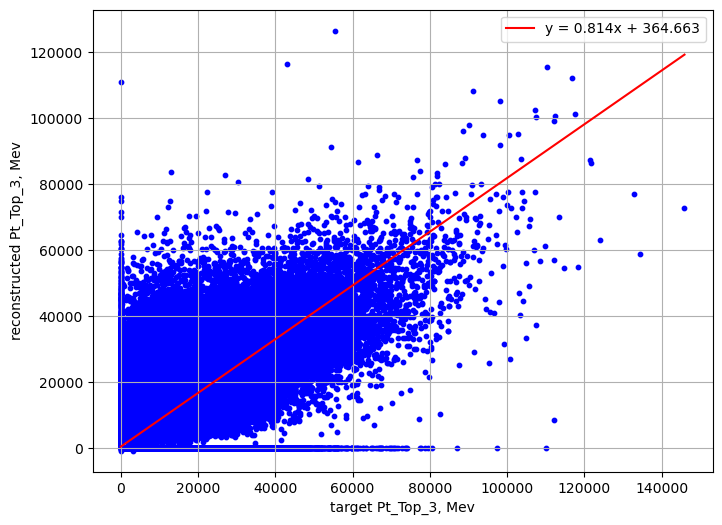

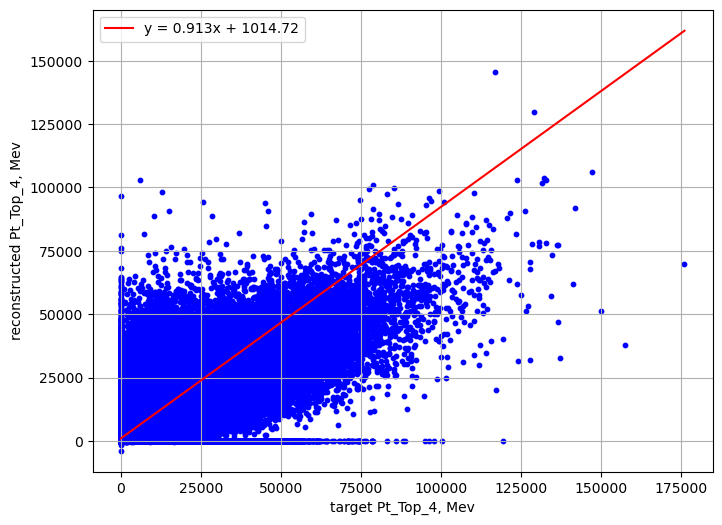

In [301]:
for i in range(1,5): 
    linreg = LinearRegression(fit_intercept=True)
    linreg = linreg.fit((reconst_events_new[f'Pt_GenTop{i}'].values*100).reshape(-1,1), df_val_new[f'Pt_GenTop{i}'].values.reshape(-1,1))
    x_line = np.linspace(df_val_new[f'Pt_GenTop{i}'].min(), df_val_new[f'Pt_GenTop{i}'].max(), 1639686).reshape(-1, 1)
    y_line = linreg.predict(x_line)

    plt.figure(figsize=(8,6))
    plt.plot(x_line, y_line, color='red', label=f'y = {round(linreg.coef_[0][0], 3)}x + {round(linreg.intercept_[0], 3)}')
    plt.scatter(df_val_new[f'Pt_GenTop{i}'].values, reconst_events_new[f'Pt_GenTop{i}'].values*100, color='Blue', s=10)
    plt.xlabel(f'target Pt_Top_{i}, Mev')
    plt.ylabel(f'reconstructed Pt_Top_{i}, Mev')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'results/results_ae_reg/pt_vs_pt_top{i}')
    plt.show()


In [311]:
coefs = []
for i in range(1,5):
    linreg = LinearRegression(fit_intercept=True)
    linreg = linreg.fit((reconst_events_new[f'Pt_GenNu{i}'].values).reshape(-1,1), df_val_new[f'Pt_GenNu{i}'].values.reshape(-1,1))
    coef = linreg.coef_[0][0]
    coefs.append(coef)
final_coef = np.mean(coefs)


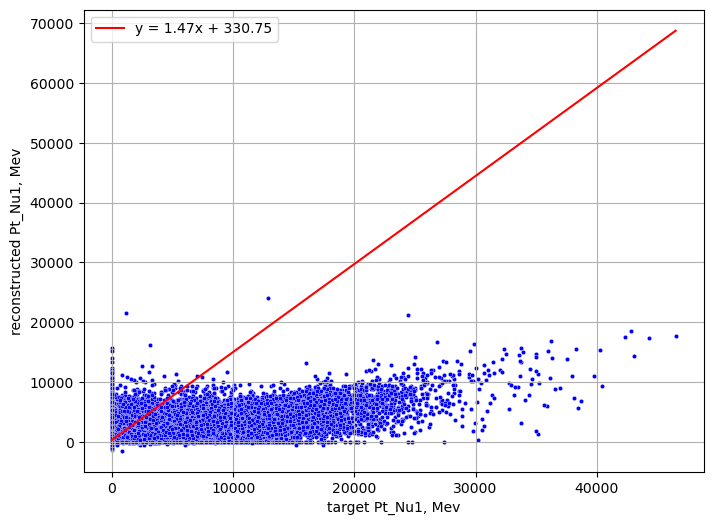

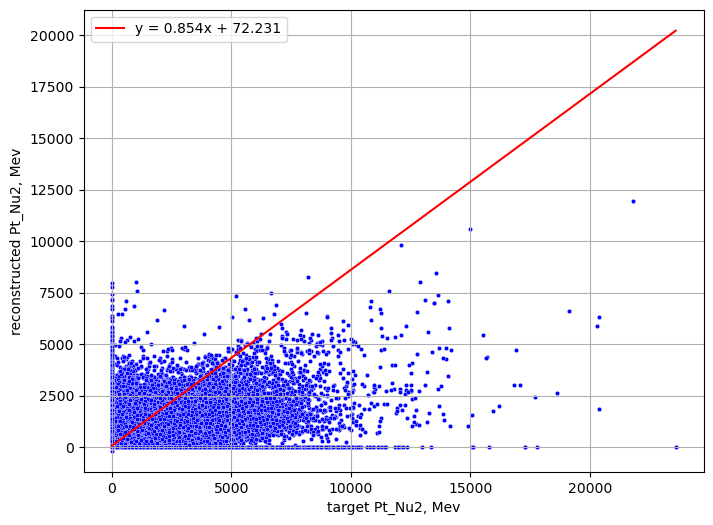

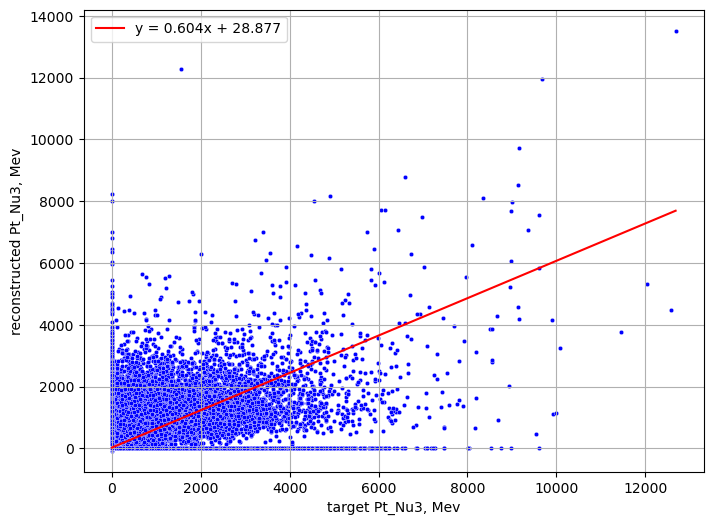

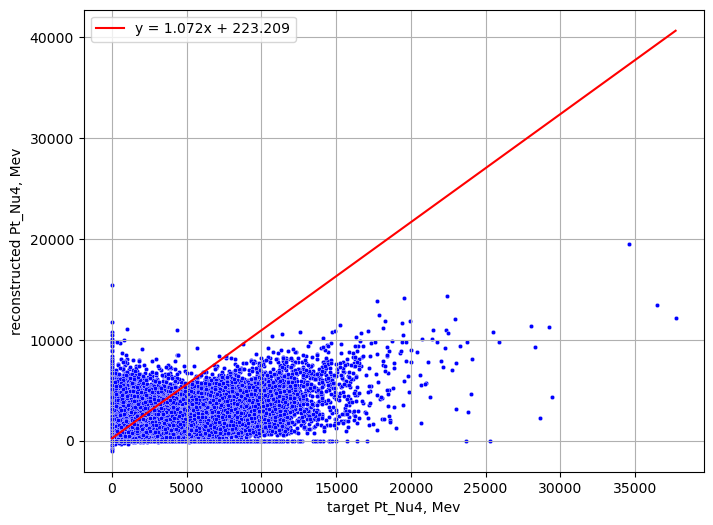

In [313]:
for i in range(1,5): 
    
    linreg = LinearRegression(fit_intercept=True)
    linreg = linreg.fit((reconst_events_new[f'Pt_GenNu{i}'].values*final_coef).reshape(-1,1), df_val_new[f'Pt_GenNu{i}'].values.reshape(-1,1))
    x_line = np.linspace(df_val_new[f'Pt_GenNu{i}'].min(), df_val_new[f'Pt_GenNu{i}'].max(), 1639686).reshape(-1, 1)
    y_line = linreg.predict(x_line)

    plt.figure(figsize=(8,6))
    plt.plot(x_line, y_line, color='red', label=f'y = {round(linreg.coef_[0][0], 3)}x + {round(linreg.intercept_[0], 3)}')
    sns.scatterplot(x = df_val_new[f'Pt_GenNu{i}'].values, y=reconst_events_new[f'Pt_GenNu{i}'].values*final_coef, color='Blue', s=10)
    plt.xlabel(f'target Pt_Nu{i}, Mev')
    plt.ylabel(f'reconstructed Pt_Nu{i}, Mev')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'results/results_ae_reg/nu_vs_nu_top{i}')
    plt.show()
